In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

In [2]:
import keras
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
from pandas import read_csv
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import isfile
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import os
import math
from datetime import datetime

In [4]:
import os
import pandas as pd

TRAIN_PATH = '../datasets/casia/bbox/'
#TEST_PATH = '../datasets/casia/test_bbox/'


In [5]:
from os.path import isfile

In [6]:
tagged = {}
join = []
#submit = os.listdir('../datasets/casia/test_/')
train_dataset = os.listdir(TRAIN_PATH)

for i in range(len(train_dataset)):
    tagged[train_dataset[i]] = train_dataset[i].split(':')[0]
    
#join = list(tagged.keys()) + submit

len(tagged),#len(submit),len(join),list(tagged.items())[:5],submit[:5]

(452960,)

In [7]:
Id2p = {}

for p in tqdm(train_dataset):
    Id = p.split(':')[0]
    if Id not in Id2p: Id2p[Id] = []
    if p not in Id2p[Id]: Id2p[Id].append(p)
        
print(len(Id2p))


10575


In [8]:
num_classes = len(Id2p)

In [9]:
train = os.listdir(TRAIN_PATH)

trainId2p = {}

for p in tqdm(train):
    Id = p.split(':')[0]
    if Id not in trainId2p: trainId2p[Id] = []
    if p not in trainId2p[Id]: trainId2p[Id].append(p)
        
print(len(trainId2p))


10575


In [10]:

train = []
train_val = []

for Id,p in trainId2p.items():
    long = len(p)
    shuffle(p)
    if long>1:
        train_val.append(p[long-1])
        for i in range(0,long-1):
            train.append(p[i])
    else:
        for i in range(0,long):
            train.append(p[i])
            
Id2number = {}
a = 0
for Id in Id2p.keys():
    Id2number[Id] = a
    a += 1
    
print(len(train))
print(len(train_val))
print(train_val[:3])
print(len(Id2number))

442385
10575
['0059431:104.jpg', '0431645:055.jpg', '2321925:031.jpg']
10575


In [11]:
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile(TRAIN_PATH + str(p)): return TRAIN_PATH + str(p)
    if isfile(TEST_PATH + str(p)): return TEST_PATH + str(p)
    return p


def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    #if p in rotate: img = img.rotate(180)
    return img

In [12]:
import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
import cv2
from matplotlib import pyplot as plt
import numpy as np

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def strong_aug(p=0.7):
    return Compose([
        #RandomRotate90(),
        #Flip(),
        HorizontalFlip(),
        #OneOf([
        #    IAAAdditiveGaussianNoise()
        #], p=0.3),
        #OneOf([
        #    MotionBlur(p=0.3),
        #    MedianBlur(blur_limit=1, p=0.3),
        #    Blur(blur_limit=1, p=0.3),
        #], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=0),
        #CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.35),
        #OneOf([
        #    IAASharpen(),
        #    IAAEmboss(),
        #], p=0.3),
    ], p=p)

aug = strong_aug(p=0.7)

In [13]:
img_shape = (112,96,3)

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p)#.convert('L')
    img   = img_to_array(img)
        
    img   = img.astype('uint8')
    
    
    if img.shape[2] == 1:
        img = np.stack((img[..., 0],) * 3, axis=-1)
    
    if augment:
        augmented = aug(image=img)
        img = augmented['image']

    
    img = cv2.resize(img,(img_shape[1],img_shape[0]))

    img   = img.astype('float64')
    #img = img.astype('uint8')
    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) #+ K.epsilon()
    #img -= 127.5
    #img = img/255
    #img = img.reshape(img.shape[0],img.shape[1],1)
    
    
    return img

In [14]:
def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

In [15]:

img = read_cropped_image(train_dataset[39], True)

#img = np.squeeze(img)
img = img*255+127.5
img = img.astype('uint8')
#print(img)
img2 = read_cropped_image(train_dataset[39],False)
img2 = img2*255+127.5
img2 = img2.astype('uint8')
#img2 = np.squeeze(img2)

img3 = read_cropped_image(train_dataset[433], True)
img3 = img3*255+127.5
#img = np.squeeze(img)
img3 = img3.astype('uint8')
#print(img)
img4 = read_cropped_image(train_dataset[433],False)
img4 = img4*255+127.5
img4 = img4.astype('uint8')

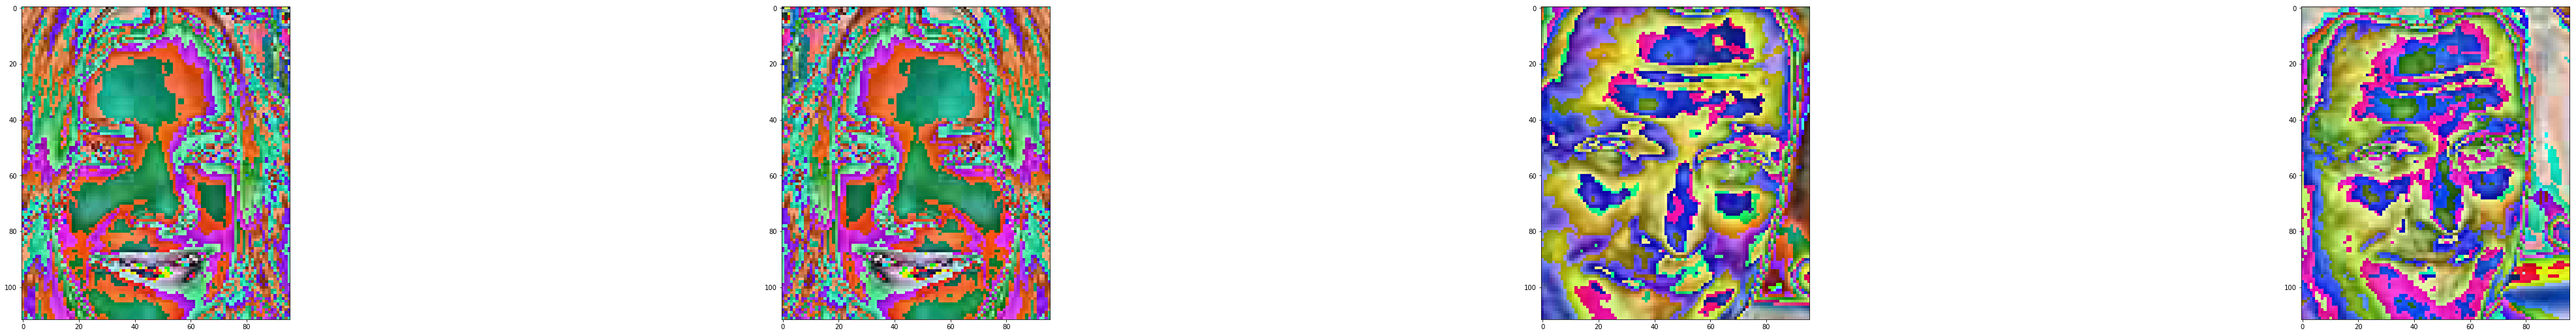

In [16]:
fig = plt.figure(figsize = (80, 30))
y = fig.add_subplot(3, 4, 1)
plt.imshow(img2)
y = fig.add_subplot(3, 4, 2)
plt.imshow(img)
y = fig.add_subplot(3, 4, 3)
plt.imshow(img3)
y = fig.add_subplot(3, 4, 4)
plt.imshow(img4)

In [17]:
label = []
for p in train_dataset:
    label.append(p.split(':')[0])

# Find all images associated with a given phash value.
all_label = []
for p in train_dataset:
    Id = p.split(':')[0]
    all_label.append(Id)
    #if p not in h2ps[h]: h2ps[h].append(p)
    
print(len(all_label))

452960


In [21]:
import keras

class TrainingGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,batch_size=32, dim=(112,96) ,n_classes=num_classes,n_channels=3,
                 shuffle=True,augmentation=False):
        'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.list_IDs) / self.batch_size) ))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = read_cropped_image(ID,self.augmentation)
            
            # Store class
            label =  ID.split(':')[0]
            #label = p2Id[ID]
            label = Id2number[label]
            
            y[i] = label

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [22]:
# Test on a batch of 32 with random costs.
#score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingGenerator(train,Id2number,n_classes=num_classes)
a, c = data[0]
a.shape, c.shape


((32, 112, 96, 3), (32, 10575))

In [24]:
import keras
from keras.applications.resnet50 import ResNet50

backbone = ResNet50(input_shape=(112,96,3), weights='imagenet', include_top=False)

W0603 11:54:33.124852 140151287752512 deprecation.py:506] From /home/iilab/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/home/iilab/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
import keras
from keras.engine.topology import Layer
from keras import backend as K
from keras.initializers import Constant
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.models import Model
import math

In [26]:
class Dense_with_Arcface_loss(Layer): #Perfection ! 

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Dense_with_Arcface_loss, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Dense_with_Arcface_loss, self).build(input_shape)
        #self.kernel = K.l2_normalize(self.kernel,0)

    def call(self, inputs):
        inputs = tf.nn.l2_normalize(inputs, dim=1)  # input_l2norm
        self.kernel = tf.nn.l2_normalize(self.kernel, dim=0)   # W_l2norm

        cosine = K.dot(inputs, self.kernel)  # cos = input_l2norm * W_l2norm
        return cosine

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

   

In [27]:
def Arcface_loss(y_true, y_pred,m=0.35,scale=50.,num_classes=num_classes):
        #Parameters  
        cos_m = math.cos(m) 
        sin_m = math.sin(m) 
        threshold = math.cos(math.pi - m)
        mm = math.sin(math.pi - m) * m
        
        cos_t = y_pred
        
        cos_t2 = K.tf.square(cos_t, name='cos_2')
        sin_t2 = K.tf.subtract(1., cos_t2, name='sin_2')
        sin_t = K.tf.sqrt(sin_t2, name='sin_t')
        cos_mt = scale * tf.subtract(K.tf.multiply(cos_t, cos_m), K.tf.multiply(sin_t, sin_m), name='cos_mt')

        cond_v = cos_t - threshold
        cond = tf.cast(K.tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

        keep_val = scale*(cos_t - mm)
        cos_mt_temp = K.tf.where(cond, cos_mt, keep_val)

        mask = y_true
        
        inv_mask = K.tf.subtract(1., mask, name='inverse_mask')

        s_cos_t = K.tf.multiply(scale, cos_t, name='scalar_cos_t')

        output = K.tf.add(K.tf.multiply(s_cos_t, inv_mask), K.tf.multiply(cos_mt_temp, mask), name='arcface_loss_output')

        cross_ent = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=output)
        loss = tf.reduce_mean(cross_ent)
        
        return loss


In [28]:
def CosineFaceLoss(y_true, y_pred,m=0.35,scale=30.,num_classes=num_classes):

    cosine = y_pred

    cosine = tf.clip_by_value(cosine, -1, 1, name='cosine_clip') - m * y_true
    
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,
        logits=scale * cosine), name='cosine_loss')

In [29]:
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Conv2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam

def create_model(backbone,lr):
    
    input_shape = (112,96, 3)
    inp = Input(shape=input_shape)
    
    for layer in backbone.layers:
        layer.trainable = True
        
    feature = backbone(inp)
    feature = GlobalAveragePooling2D()(feature) # 0.294
    #feature = GlobalMaxPooling2D()(feature)
    feature = BatchNormalization()(feature)
    

        
    Arcface_softmax_logits = Dense_with_Arcface_loss(num_classes)
    out = Arcface_softmax_logits(feature)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss=Arcface_loss, optimizer='Adam', metrics=['acc'])
    
    return model

In [30]:
model = create_model(backbone,64e-2)
#model,branch_model = create_model(backbone,64e-2)

W0603 11:55:05.287510 140151287752512 deprecation.py:506] From <ipython-input-26-8efcd3911ed1>:19: calling l2_normalize (from tensorflow.python.ops.nn_impl) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead
W0603 11:55:05.319141 140151287752512 deprecation.py:323] From <ipython-input-27-bce830354592>:29: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [31]:
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x112-55-3.826-0.888-20190425_102216.model')

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 112, 96, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_with__arcface_loss_1 ( (None, 10575)             21657600  
Total params: 45,253,504
Trainable params: 45,196,288
Non-trainable params: 57,216
_________________________________________________________________


In [33]:
print(len(train))
print(len(train_val))

442385
10575


In [34]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.utils import shuffle
from keras.callbacks import CSVLogger



def make_steps(step):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global train,train_val,steps, histories
    
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1, monitor='val_acc', mode='max')
    early_stopping = EarlyStopping(patience=10, verbose=1, monitor='val_acc', mode='max')
    # Create a TensorBoard logger
    csv_logger = CSVLogger('log.csv', append=True, separator=';')
    
    
    # Parameters
    params = {'dim': (img_shape[0],img_shape[1]),
          'n_classes' : num_classes,
          'batch_size': 64,
          'n_channels': 3,
          'shuffle': True
             }

    # Datasets
    train = shuffle(train, random_state=0)
    train_val = shuffle(train_val, random_state=0)
    

    # Generators
    training_generator = TrainingGenerator(train, Id2number ,**params,augmentation=True)
    validation_generator = TrainingGenerator(train_val, Id2number ,**params,augmentation=False)
    
    # Train the model for 'step' epochs
    history = model.fit_generator(
        generator=training_generator,
        validation_data=validation_generator, 
        initial_epoch=steps, epochs=steps + step, verbose=0,
        callbacks=[ModelCheckpoint('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-{epoch:02d}-{loss:.3f}-{val_acc:.3f}.model', monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
                   reduce_lr,
                   csv_logger,
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step
    
    # Collect history data
    history['epochs'] = steps
    print(history['epochs'])
    histories.append(history)

In [35]:
def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

In [36]:
histories = []
steps = 0

In [ ]:
set_lr(model,0.1)

make_steps(100)


Epoch 00001: val_acc improved from -inf to 0.03258, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-01-24.708-0.033.model



Epoch 00002: val_acc improved from 0.03258 to 0.25502, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-02-20.762-0.255.model



Epoch 00003: val_acc improved from 0.25502 to 0.48826, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-03-16.284-0.488.model



Epoch 00004: val_acc improved from 0.48826 to 0.58106, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-04-13.969-0.581.model



Epoch 00005: val_acc improved from 0.58106 to 0.64223, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-05-12.576-0.642.model



Epoch 00006: val_acc improved from 0.64223 to 0.68504, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-06-11.552-0.685.model



Epoch 00007: val_acc improved from 0.68504 to 0.72652, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-07-10.737-0.727.model



Epoch 00008: val_acc improved from 0.72652 to 0.74659, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-08-10.117-0.747.model



Epoch 00009: val_acc improved from 0.74659 to 0.75322, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-09-9.598-0.753.model



Epoch 00010: val_acc improved from 0.75322 to 0.77822, saving model to ../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x96-10-9.179-0.778.model


In [ ]:
set_lr(model,0.032)

make_steps(400)

In [ ]:
set_lr(model,0.001)

make_steps(50)

In [ ]:
set_lr(model,0.001)

make_steps(250)

In [ ]:
#from keras.models import load_weights

model.load_weights('../state-of-art/model-checkpoint/Arcface-47-0.196-0.499.model')

In [ ]:
make_steps(100)

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
#weights = model.get_weights()
#model, branch_model = create_model(backbone,64e-2)
#model.set_weights(weights)

In [ ]:
test = os.listdir('../datasets/casia/test_bbox/')

In [ ]:
class TestGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=1, dim=(128,64) ,n_channels=3,n_classes = num_classes,
                 augmentation=False):
        'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.augmentation = augmentation
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.list_IDs) / self.batch_size) ))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = read_cropped_image(ID,self.augmentation)
            
            Id =  ID.split('_')[0]
            y[i] = Id2number[Id] 

        return X,keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
test_generator = TestGenerator(submit,batch_size=1, dim=(112, 112))


#layer_name = 'batch_normalization_35'
#branch_model = Model(inputs=model.input,
#                                 outputs=model.get_layer(layer_name).output)

#preds = branch_model.predict_generator(test_generator,verbose=1)

In [ ]:
#print(intermediate_output.shape)

In [ ]:
number2Id = {}

for Id,number in Id2number.items():
    number2Id[number] = Id

In [ ]:
model.evaluate_generator(test_generator, verbose=1)